In [73]:
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import multiprocessing as mp
# from collections import OrderedDict
# # import datetime
# import gc
# from itertools import islice
# import datetime
# import powerlaw
# from scipy import optimize
# from scipy.special import erf, gamma
# from scipy import optimize
from IPython.display import clear_output
import warnings
from operator import itemgetter

# [Technical] Generation functions

In [14]:
def generateCGW(mean):
    g = nx.Graph()
    g.add_node(0, root = True)
    num_root_offsprings = np.random.poisson(mean)
    node_count = 1
    default_weight = 1.0
    offspring_to_generate = []
    for i in range(0,num_root_offsprings):
        g.add_node(node_count, root = False)
        g.add_edge(0, node_count, weight = default_weight)
        offspring_to_generate.append(node_count)
        node_count+=1
    while offspring_to_generate:
        if nx.number_of_nodes(g)>10000:
            return g, False
        u = offspring_to_generate[0]
        del offspring_to_generate[0]
        num_offsprings = np.random.poisson(mean)
        for i in range(0,num_offsprings):
            g.add_node(node_count, root = False)
            g.add_edge(u, node_count, weight = default_weight)
            offspring_to_generate.append(node_count)
            node_count+=1
    return g, True

def get_tree_depth(tree):
    shortest_path_dict = nx.single_source_shortest_path_length(tree, source = 0)
    return max(shortest_path_dict.values())

def generateCGWConditionedDepth(depth, extra_edge):
    while True:
        g, success = generateCGW(1)
        if success and get_tree_depth(g) > depth:
            break
    if extra_edge:
        v = np.random.randint(low=1, high=nx.number_of_nodes(g)-1)
        g.add_edge(0,v)
    return g

def getPowerlawRandom(alpha):
    while True:
        x = np.random.uniform(low=0, high=1)
        t = np.power((1/(1-x)), 1/alpha)
        if t>1:
            return t

def getSpreadingCurve(g,root, alpha):
    for e in g.edges():
        g.edge[e[0]][e[1]]['weight']=getPowerlawRandom(alpha)
    dictT = nx.single_source_dijkstra_path_length(g,root, weight = 'weight')
    arrayT = sorted(dictT.values())
    return arrayT

def getAverageSpreadingCurve(M,g,root,alpha):
    averageT = [0 for t in range(0,nx.number_of_nodes(g))]
    for i in range(0,M):
        #print('Running:', i, 'out of', M)
        currentT = getSpreadingCurve(g,root,alpha)
        for j in range(0,len(currentT)):
            averageT[j] += currentT[j]
    averageT = [t/M for t in averageT]
    fractionT = [k/nx.number_of_nodes(g) for k in range(1,nx.number_of_nodes(g)+1)]
    return averageT, fractionT


### Run M simulations and output average spreading curve

In [44]:
depth = 10
extra_edge = True
g = generateCGWConditionedDepth(depth, extra_edge)
print('Number of nodes: ', nx.number_of_nodes(g))
print('Number of edges: ', nx.number_of_edges(g))

Number of nodes:  71
Number of edges:  71


Run 9


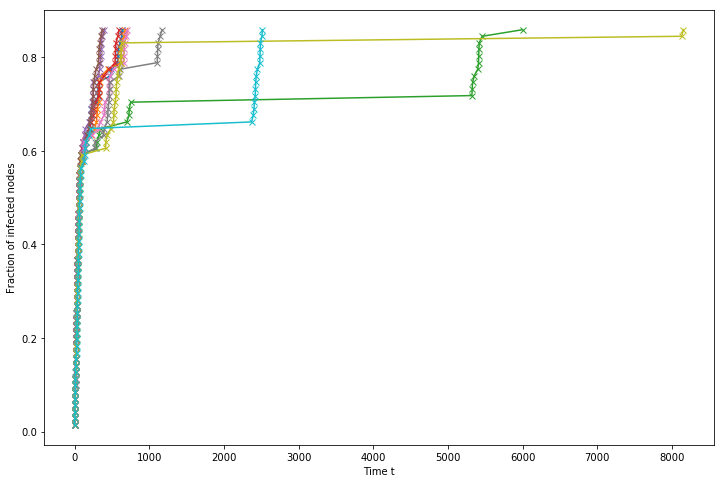

In [45]:
alpha = 0.8
M=400
fig = plt.figure(figsize=(12,8))
for i in range(0,10):
    if i%3==0:
        clear_output()
        print('Run', i) 
    averageT, fractionT = getAverageSpreadingCurve(M,g,0,alpha)
    plt.plot(averageT[:-10], fractionT[:-10], marker='x')

plt.xlabel('Time t')
plt.ylabel('Fraction of infected nodes')
plt.show()

In [7]:
def generateLCCErdosRenyi(n,p):
    g = nx.erdos_renyi_graph(n,p)
    graphs = list(nx.connected_component_subgraphs(g))
    h = max(graphs, key=lambda x: nx.number_of_nodes(x))
    root_marks = [False for i in range(0,nx.number_of_nodes(g))]
    default_weights = [0 for i in range(0,nx.number_of_edges(g))]
    nx.set_node_attributes(h,'root',root_marks)
    nx.set_edge_attributes(h, 'weight', default_weights)
    return h


### Statistics for LCC size and extra edge number

In [95]:
lbd = 2
n=3000
p=1/n+lbd/np.power(n,4/3)
array_extra_edge_counts_p = []
array_sizes_lcc_p = []

def parallel_function(i):
    if i%10==0:
        clear_output()
        print('Run number:', i)
    h = generateLCCErdosRenyi(n,p)
    array_extra_edge_counts_p.append(nx.number_of_edges(h) - nx.number_of_nodes(h) + 1)
    array_sizes_lcc_p.append(nx.number_of_nodes(h))
    return i

pool = mp.Pool(processes=4)
parallel_results = [pool.apply_async(parallel_function, args=(i,)) for i in range(0,100)]
parallel_output = [p.get() for p in parallel_results]
if len(parallel_results)==1001:
    print('DONE!')

Run number: 990


In [97]:
array_extra_edge_counts = array_extra_edge_counts_p
array_sizes_lcc = array_sizes_lcc_p

print('Lambda:', lbd)
print('Average extra edge counts:', np.mean(array_extra_edge_counts), lbd, ': true value')
print('Average size of LCC:', np.mean(array_sizes_lcc), np.power(n,2/3), ': true value $n^{2/3}$')

linbins = np.linspace(0,max(array_extra_edge_counts), max(array_extra_edge_counts)+1)
# weights = [1/100000 for i in range(0,len(bunch_hawkes_root))]
# plt.figure(figsize=(8,6))
hist, bins = np.histogram(array_extra_edge_counts, bins=linbins, normed=True)
plot_label = 'Simulation ' + str(len(array_extra_edge_counts)) + ' times'
plt.plot(bins[:-1], hist, marker='.', alpha = 0.8, label=plot_label)
plt.xlabel('Number of extra edges')
plt.ylabel('pdf')

linbins = np.linspace(min(array_sizes_lcc),max(array_sizes_lcc), int(np.sqrt(len(array_sizes_lcc))))
# weights = [1/100000 for i in range(0,len(bunch_hawkes_root))]
plt.figure(figsize=(6,4))
hist, bins = np.histogram(array_sizes_lcc, bins=linbins, normed=True)
plot_label = 'Simulation ' + str(len(array_sizes_lcc)) + ' times'
plt.plot(bins[:-1], hist, marker='.', alpha = 0.8, label=plot_label)
plt.xlabel('Sizes of LCCs')
plt.ylabel('pdf')
plt.show()

Lambda: 2
Average extra edge counts: nan 2 : true value
Average size of LCC: nan 208.008382305 : true value $n^{2/3}$


ValueError: max() arg is an empty sequence

In [12]:
# TEST
n=1000
p=1/n+2/np.power(n,4/3)
g = nx.erdos_renyi_graph(n,p)
graphs = list(nx.connected_component_subgraphs(g))
print(len(graphs))
h = max(graphs, key=lambda x: nx.number_of_nodes(x))
root_marks = [False for i in range(0,nx.number_of_nodes(g))]
default_weights = [0 for i in range(0,nx.number_of_edges(g))]
nx.set_node_attributes(h,'root',root_marks)
nx.set_edge_attributes(h, 'weight', default_weights)
print(nx.info(h))

376
Name: gnp_random_graph(1000,0.0012)
Type: Graph
Number of nodes: 393
Number of edges: 399
Average degree:   2.0305


In [64]:
n=1000
lbd = 0
p=1/n+lbd/np.power(n,4/3)
er_graph = generateLCCErdosRenyi(n,p)
print(nx.info(er_graph))
root = np.random.choice(er_graph.nodes())

Name: gnp_random_graph(1000,0.001)
Type: Graph
Number of nodes: 139
Number of edges: 140
Average degree:   2.0144


Run 9


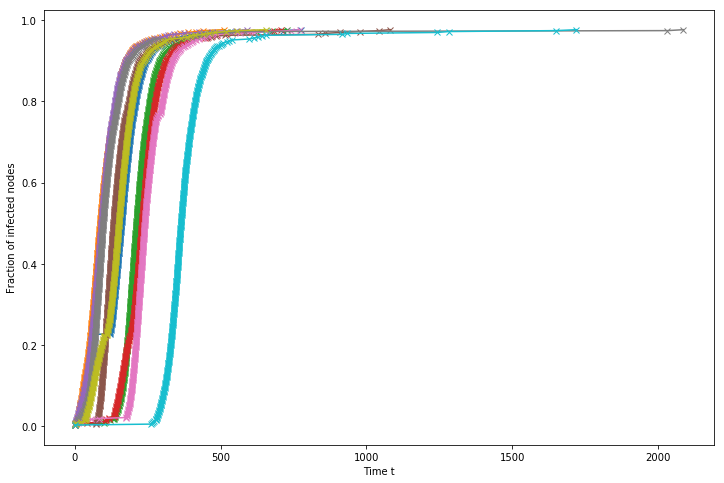

In [58]:
alpha = 0.8
M=400
fig = plt.figure(figsize=(12,8))
for i in range(0,10):
    if i%3==0:
        clear_output()
        print('Run', i) 
    root = np.random.choice(er_graph.nodes())
    averageT, fractionT = getAverageSpreadingCurve(M,er_graph,root,alpha)
    plt.plot(averageT[:-10], fractionT[:-10], marker='x')
plt.xlabel('Time t')
plt.ylabel('Fraction of infected nodes')
plt.show()

#### Output the graph

Number of nodes:  435


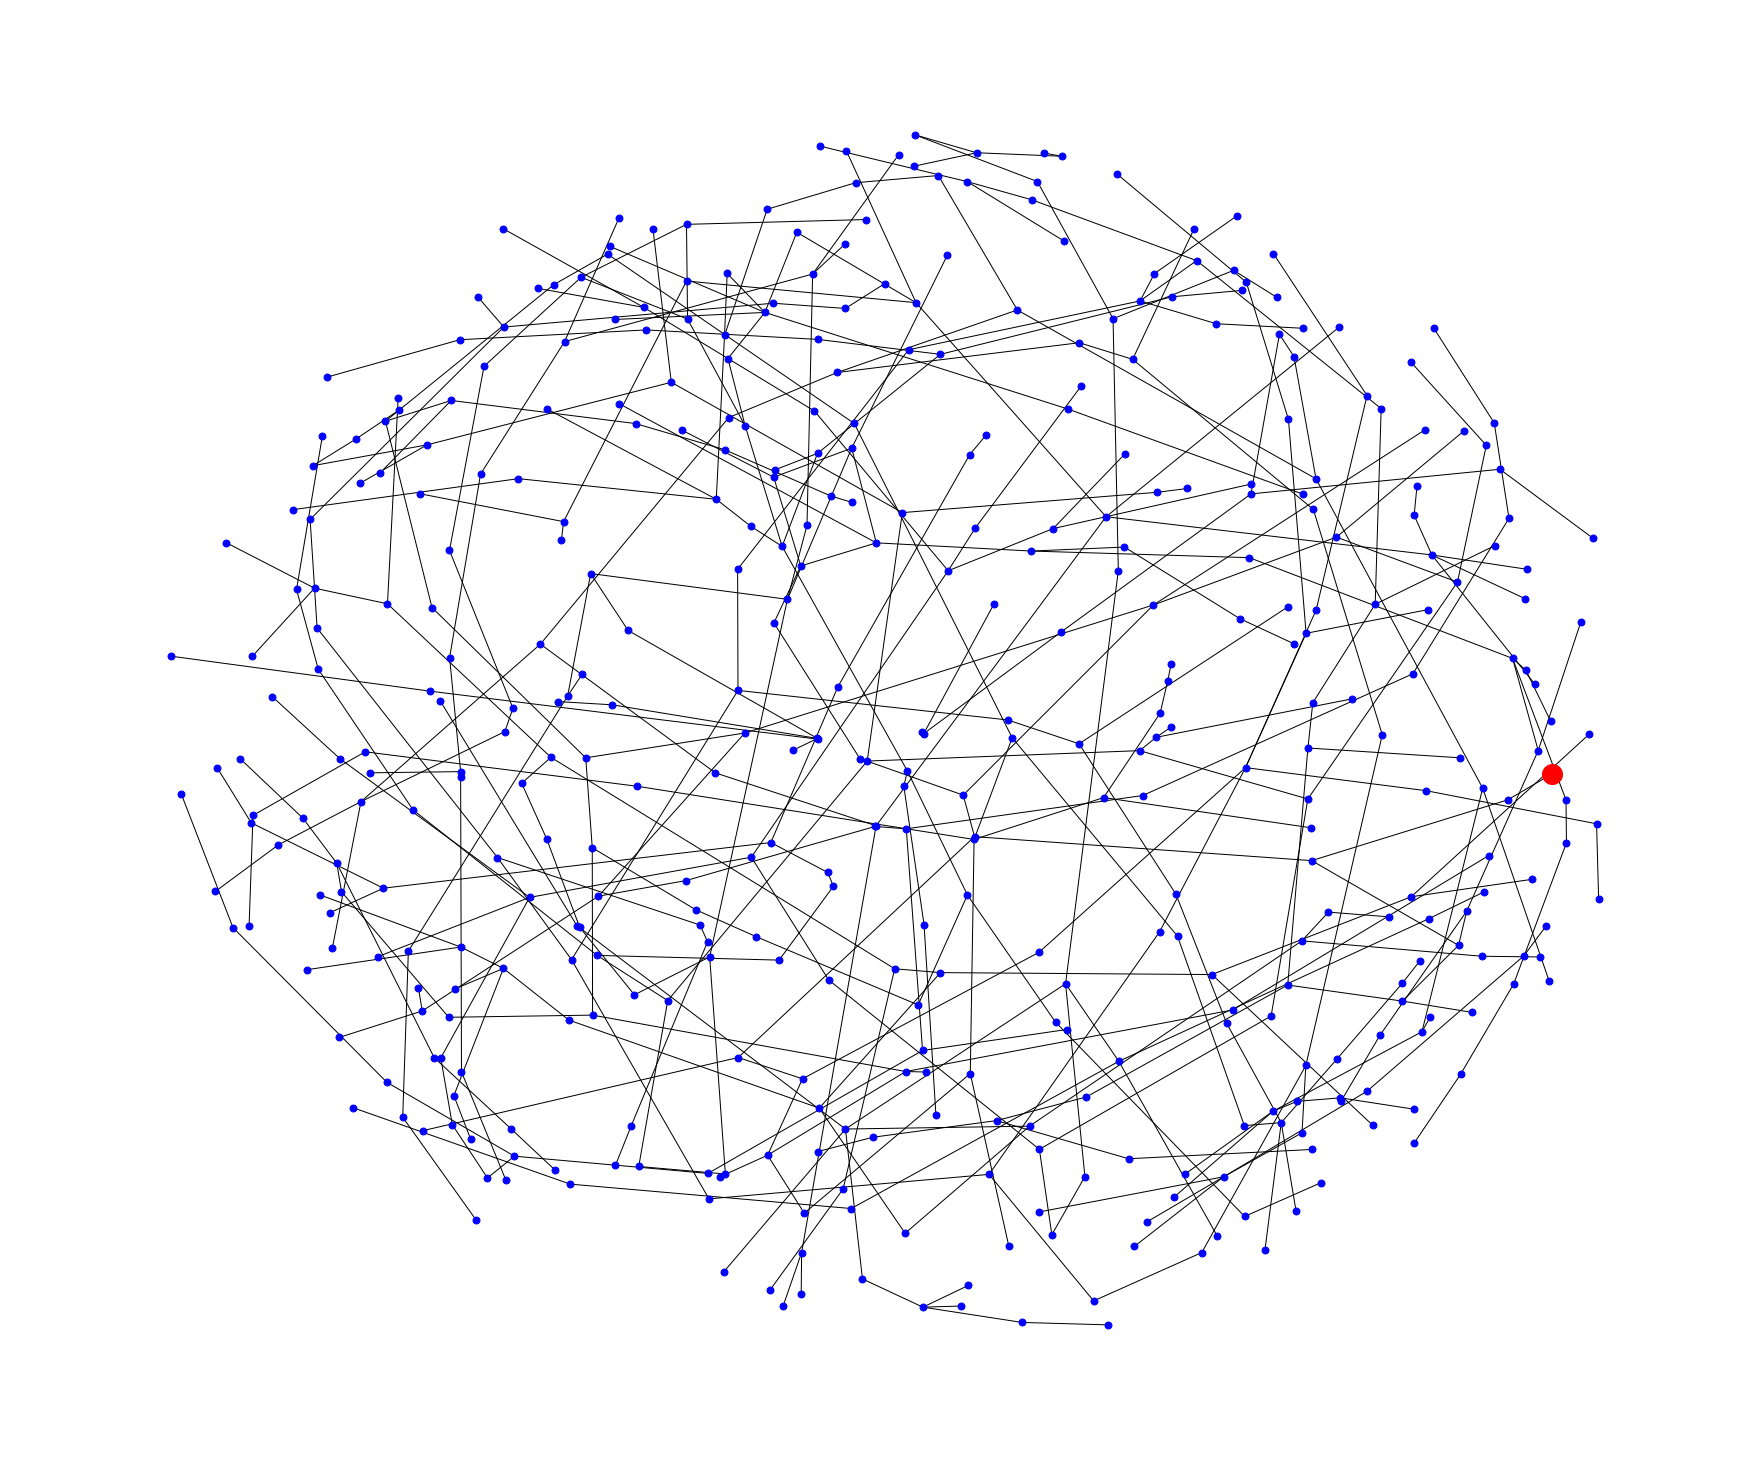

In [57]:
warnings.filterwarnings("ignore")
print('Number of nodes: ', nx.number_of_nodes(er_graph))
plt.figure(figsize=(24,20), dpi=72, frameon=False)
pos=nx.spring_layout(er_graph, iterations = 25, scale = 5)
nx.draw(er_graph,pos,node_color='b',node_size=48, with_labels=False)
nx.draw_networkx_nodes(er_graph,pos,nodelist=[root],node_size=400,node_color='r')
plt.show()